In [ ]:
import pandas as pd
import os
import numpy as np
from scipy import signal
from mne.filter import resample

def filter_signal(dat:np.ndarray, 
                  band=[1,50], 
                  sampling_rate:int=500):
    # data: 1D array
    [b, a] = signal.iirnotch(60, 30, sampling_rate) # power noise
    dat = signal.filtfilt(b, a, dat)
    [b, a] = signal.butter(3, band, 'bandpass', fs=sampling_rate)
    dat = signal.filtfilt(b, a, dat)
    # dat =  np.convolve(dat, np.ones(sampling_rate//20) / (sampling_rate//20), mode='same')
    return dat

def preprocess_emotion(path1, fs):
    #emotion
    subj_list = os.listdir(path1)
    print(subj_list)

    eeg = []

    for idx, subj in enumerate(subj_list):
        dat_list = os.listdir(path1+subj)
        # print(subj, dat_list[0])
        easy_ = np.asarray(pd.read_csv(path1 + subj + '/' + dat_list[0], delimiter='\t'), float).T
        easy = easy_[:8,0::2]
        easy = resample(easy, down=500//fs)
        easy = filter_signal(easy, sampling_rate=125)
        eeg.append(np.stack([easy[:,i*1250:(i+1)*1250] for i in range(easy.shape[1]//(1250))], 0))
    return np.concatenate(eeg)

def preprocess_d2(path2, fs):
    eeg = []
    subj_list = os.listdir(path2)
    for idx, subj in enumerate(subj_list):
        dat_list = os.listdir(path2+subj+'/d2/')
        num1 = 2 if len(dat_list) < 7 else 3

        easy_ = np.asarray(pd.read_csv(path2 + subj + '/d2/' + dat_list[num1], delimiter='\t'), float).T
        easy = easy_[:8,0::2]
        event = np.append(np.where(easy_[8]==4)[0][0], np.where(easy_[8]==5)[0][-1])//8
        easy = resample(easy, down=500//fs)
        easy = filter_signal(easy, sampling_rate=125)
        easy = easy[:,event[0]:event[1]]
        eeg.append(np.stack([easy[:,i*1250:(i+1)*1250] for i in range(easy.shape[1]//(1250))], 0))
    return np.concatenate(eeg)

def preprocess_transfer_data(path:str, fs:int=125):
    path1 = path + '/Day 1/'
    path2 = path + '/Day 2/'

    eeg_emotion = preprocess_emotion(path1, fs)
    eeg_d2 = preprocess_d2(path2, fs)




    np.savez_compressed(f'{path}/transfer_data.npz', 
                        eeg=eeg, 
                        eeg_resting=eeg_resting, 
                        label_rating=label_rating, 
                        label_target=label_target)
    
preprocess_emotion_data('D:/One_한양대학교/private object minsu/coding/data/samsung_2024')

In [5]:
import numpy as np
a = np.zeros((8,101760))
a = np.stack([a[:,i*1250:(i+1)*1250] for i in range(a.shape[1]//(1250))])
b = np.zeros((8,69832))
b = np.stack([b[:,i*1250:(i+1)*1250] for i in range(b.shape[1]//(1250))])
np.concatenate([a,b,a]).shape

(217, 8, 1250)

In [8]:
from transfer_modules import Transfer_DataModule_2
dataset = Transfer_DataModule_2('D:\One_한양대학교\private object minsu\coding\data\samsung_2024',
                                stress=True,
                                emotion=True,
                                d2=True,
                                chan_mode=3,
                                window_len=5,
                                batch_size=16)
data = dataset.data        
a = [max(data[i,0]) for i in range(18268)]                       

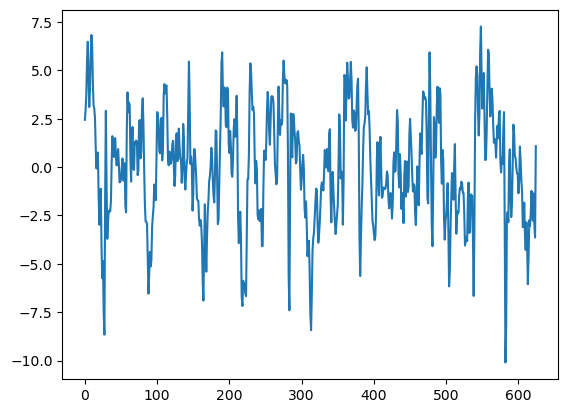

In [9]:
import matplotlib.pyplot as plt
plt.plot(data[6500,0])
# plt.plot(data[0,1])
plt.show()

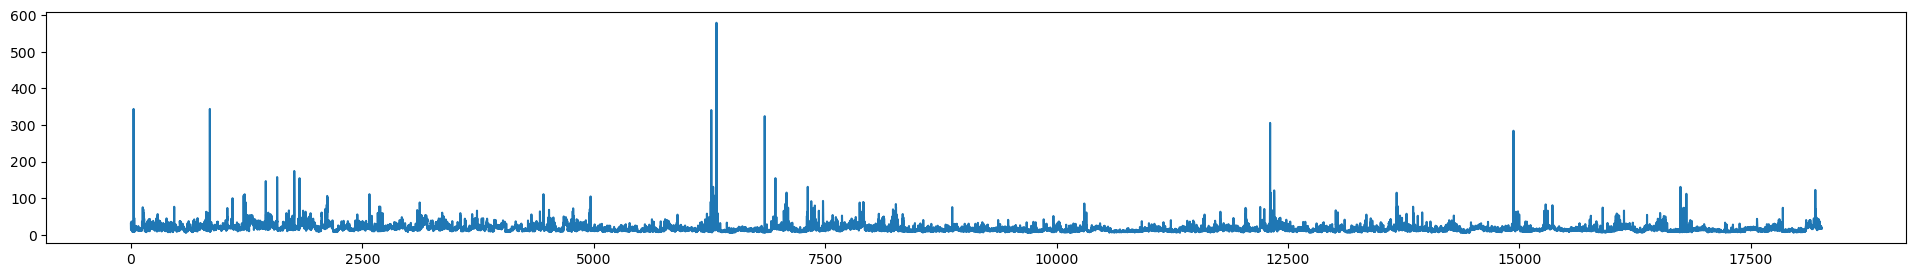

In [10]:
plt.figure(figsize=(24,3))
plt.plot(a)
# plt.xticks(range(18268))